```
         Copyright Rein Halbersma 2020-2021.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

# Chapter 5 Monte Carlo Methods

## 5.1 Monte Carlo Prediction

In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from doctrina.algorithms import dp, mc
from doctrina.spaces import shape, size, state_table
import gym_blackjack_v1 as bj

env = gym.make('Blackjack-v1', model_based=True)
env.seed(47110815)

[47110815]

**Example 5.1: Blackjack**

## The payout

In [2]:
pd.DataFrame(
    env.payout,
    index=bj.count_labels,  # player count
    columns=bj.count_labels # dealer count
)

,BUST,<17,17,18,19,20,21,BJ
BUST,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
<17,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
17,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
18,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0
19,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0
20,1.0,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0
21,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-1.0
BJ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [3]:
# Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.
stand_on_20 = np.full(shape(env.observation_space), bj.Action.HIT, dtype=int)
stand_on_20[bj.Hand.H20:(bj.Hand.H21 + 1), :] = bj.Action.STAND
stand_on_20[bj.Hand.S20:(bj.Hand.BJ  + 1), :] = bj.Action.STAND

In [4]:
# In any event, after 500,000 games the value function is very well approximated.
runs = [ 10_000, 500_000 ]
Vs, Ns = zip(*[ 
    mc.V_predict_ev(env, stand_on_20, episodes) 
    for episodes in runs 
])

100%|██████████| 500000/500000 [00:16<00:00, 30776.29it/s]


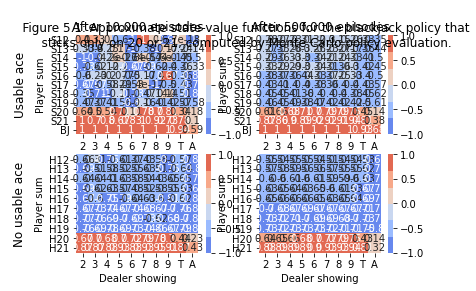

In [5]:
options = {
    'vmin': min(env.reward_range), 
    'vmax': max(env.reward_range), 
    'cmap': sns.color_palette('coolwarm'), 
    'center': 0.,
    'annot': True, 
    'xticklabels': bj.card_labels
}

hands = [
    np.arange(bj.Hand.S12, bj.Hand.BJ  + 1),
    np.arange(bj.Hand.H12, bj.Hand.H21 + 1)
]

yticklabels = [ 
    np.array(bj.hand_labels)[hands[no_usable_ace]] 
    for no_usable_ace in range(2)
]

axopts = {
    'xlabel': 'Dealer showing',
    'ylabel': 'Player sum'
}

fig, axes = plt.subplots(nrows=2, ncols=len(runs))
fig.suptitle(
    """
    Figure 5.1: Approximate state-value functions for the blackjack policy that
    sticks only on 20 or 21, computed by Monte Carlo policy evaluation.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ f'After {episodes:,} episodes' for episodes in runs ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    for r, _ in enumerate(runs):
        sns.heatmap(Vs[r][h, :], yticklabels=yticklabels[i], ax=axes[i, r], **options).set(**axopts)
plt.show()

In [6]:
pd.DataFrame(
    Vs[1],
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.5649,-0.5169,-0.3855,-0.3649,-0.5276,-0.3077,-0.5582,-0.4876,-0.5207,-0.6188
H5,-0.4855,-0.4770,-0.4563,-0.4626,-0.4858,-0.4786,-0.4025,-0.5162,-0.4997,-0.6205
H6,-0.4399,-0.5399,-0.5384,-0.4774,-0.4498,-0.4825,-0.5269,-0.5044,-0.5427,-0.6686
H7,-0.5139,-0.5188,-0.5104,-0.5021,-0.5189,-0.4606,-0.5231,-0.5533,-0.5498,-0.6565
H8,-0.5215,-0.5679,-0.5199,-0.5506,-0.5274,-0.5160,-0.5368,-0.5105,-0.5844,-0.6612
H9,-0.5408,-0.5334,-0.5069,-0.5297,-0.5131,-0.5062,-0.5053,-0.5309,-0.5748,-0.6484
H10,-0.1393,-0.1200,-0.1070,-0.0914,-0.1252,-0.0575,-0.0818,-0.1229,-0.2033,-0.4054
H11,-0.0363,-0.0636,-0.0523,-0.0922,-0.0399,-0.0702,-0.0466,-0.0832,-0.1306,-0.3451
H12,-0.5460,-0.5406,-0.5532,-0.5522,-0.5412,-0.5120,-0.5352,-0.5427,-0.5821,-0.6752
H13,-0.5664,-0.5754,-0.5900,-0.5586,-0.5620,-0.5717,-0.5525,-0.5541,-0.6162,-0.7152


In [7]:
# Although we have complete knowledge of the environment in the blackjack task, it
# would not be easy to apply DP methods to compute the value function.
policy = np.zeros(size(env.observation_space) + 1, dtype=int)
policy[:-1] = stand_on_20.reshape(size(env.observation_space))
V_dp, *_ = dp.V_policy_eval_deter_sync(env, policy, tol=1e-9)
V_dp = V_dp[:-1]
pd.DataFrame(
    state_table(V_dp, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.4783,-0.4762,-0.4741,-0.4723,-0.4656,-0.4518,-0.4483,-0.4521,-0.5195,-0.6331
H5,-0.4963,-0.4943,-0.4923,-0.4905,-0.4840,-0.4707,-0.4673,-0.4710,-0.5360,-0.6458
H6,-0.5144,-0.5125,-0.5105,-0.5088,-0.5026,-0.4897,-0.4865,-0.4900,-0.5527,-0.6585
H7,-0.5322,-0.5304,-0.5285,-0.5268,-0.5209,-0.5085,-0.5053,-0.5087,-0.5692,-0.6711
H8,-0.5539,-0.5521,-0.5503,-0.5488,-0.5431,-0.5314,-0.5285,-0.5316,-0.5887,-0.6862
H9,-0.5210,-0.5189,-0.5167,-0.5148,-0.5080,-0.4939,-0.4903,-0.4950,-0.5630,-0.6636
H10,-0.1314,-0.1271,-0.1227,-0.1188,-0.1048,-0.0760,-0.0685,-0.0797,-0.2170,-0.3908
H11,-0.0755,-0.0729,-0.0701,-0.0677,-0.0589,-0.0408,-0.0364,-0.0379,-0.1301,-0.3482
H12,-0.5449,-0.5431,-0.5413,-0.5397,-0.5339,-0.5220,-0.5190,-0.5222,-0.5805,-0.6799
H13,-0.5774,-0.5757,-0.5740,-0.5726,-0.5672,-0.5561,-0.5533,-0.5563,-0.6104,-0.7028


In [8]:
# In any event, after 500,000 games the value function is very well approximated.
pd.DataFrame(
    (Vs[1] - state_table(V_dp, env)) / state_table(V_dp, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).style.format('{:,.2%}')

,2,3,4,5,6,7,8,9,T,A
H4,18.10%,8.55%,-18.69%,-22.73%,13.33%,-31.89%,24.53%,7.86%,0.24%,-2.26%
H5,-2.18%,-3.51%,-7.30%,-5.68%,0.36%,1.69%,-13.86%,9.60%,-6.78%,-3.92%
H6,-14.49%,5.34%,5.45%,-6.18%,-10.51%,-1.48%,8.29%,2.93%,-1.81%,1.53%
H7,-3.44%,-2.18%,-3.43%,-4.71%,-0.38%,-9.42%,3.52%,8.75%,-3.40%,-2.17%
H8,-5.85%,2.85%,-5.53%,0.33%,-2.89%,-2.90%,1.58%,-3.97%,-0.74%,-3.65%
H9,3.80%,2.79%,-1.91%,2.89%,0.99%,2.49%,3.06%,7.26%,2.11%,-2.28%
H10,6.00%,-5.58%,-12.79%,-23.04%,19.42%,-24.36%,19.48%,54.35%,-6.33%,3.73%
H11,-51.93%,-12.80%,-25.46%,36.12%,-32.35%,72.33%,27.75%,119.33%,0.39%,-0.90%
H12,0.20%,-0.45%,2.21%,2.32%,1.37%,-1.92%,3.13%,3.93%,0.28%,-0.69%
H13,-1.89%,-0.06%,2.79%,-2.44%,-0.92%,2.81%,-0.16%,-0.40%,0.95%,1.76%


## 5.3 Monte Carlo Control

**Example 5.3: Solving Blackjack**

In [ ]:
episodes = 500_000
policy0 = stand_on_20
policy, Q, N = mc.control_es(env, episodes, policy0)
assert (policy == Q.argmax(axis=2)).all()
policy = Q.argmax(axis=2)
V = Q.max(axis=2)

100%|██████████| 500000/500000 [00:21<00:00, 23357.73it/s]


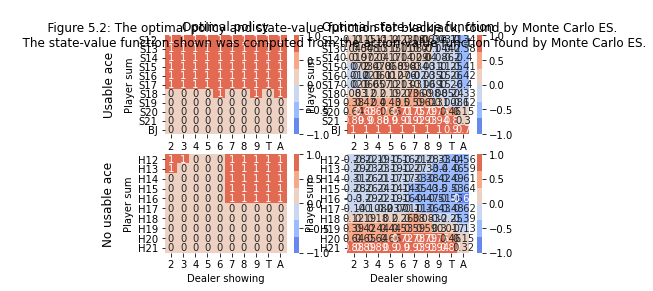

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle(
    """
    Figure 5.2: The optimal policy and state-value function for blackjack, found by Monte Carlo ES. 
    The state-value function shown was computed from the action-value function found by Monte Carlo ES.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ 'Optimal policy', 'Optimal state-value function' ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    sns.heatmap(policy[h, :], yticklabels=yticklabels[i], ax=axes[i, 0], **options).set(**axopts)
    sns.heatmap(     V[h, :], yticklabels=yticklabels[i], ax=axes[i, 1], **options).set(**axopts)
plt.show()

In [10]:
pd.DataFrame(
    V, 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.2170,-0.1435,-0.1185,0.0257,0.0814,-0.1476,-0.1293,-0.2506,-0.3258,-0.4610
H5,-0.1283,-0.1061,-0.0594,-0.0156,0.0279,-0.1445,-0.2275,-0.3120,-0.3843,-0.4484
H6,-0.1697,-0.1120,-0.1766,-0.0034,-0.0752,-0.1915,-0.2667,-0.3286,-0.3806,-0.5497
H7,-0.1459,-0.0731,-0.1059,-0.0415,0.0562,-0.0466,-0.1837,-0.2771,-0.3497,-0.4907
H8,-0.0912,0.0371,0.0047,0.0627,0.0631,0.0750,-0.0775,-0.2232,-0.2808,-0.4340
H9,0.0954,0.1358,0.1139,0.1350,0.2157,0.1360,0.0999,-0.0291,-0.2267,-0.3503
H10,0.0965,0.2124,0.1782,0.2571,0.2787,0.2463,0.1778,0.1500,-0.0546,-0.2240
H11,0.2523,0.2212,0.2974,0.3167,0.3232,0.2749,0.2397,0.1400,0.0449,-0.1668
H12,-0.2800,-0.2168,-0.1947,-0.1493,-0.1611,-0.2142,-0.2811,-0.3287,-0.4396,-0.5629
H13,-0.2904,-0.2279,-0.2283,-0.1939,-0.1163,-0.2720,-0.3322,-0.3976,-0.4558,-0.5947


In [11]:
pd.DataFrame(
    policy, 
    index=bj.hand_labels, 
    columns=bj.card_labels
).applymap(lambda a: bj.action_labels[a]).replace({'S': ' '})

,2,3,4,5,6,7,8,9,T,A
H4,H,H,H,H,H,H,H,H,H,H
H5,H,H,H,H,H,H,H,H,H,H
H6,H,H,H,H,H,H,H,H,H,H
H7,H,H,H,H,H,H,H,H,H,H
H8,H,H,H,H,H,H,H,H,H,H
H9,H,H,H,H,H,H,H,H,H,H
H10,H,H,H,H,H,H,H,H,H,H
H11,H,H,H,H,H,H,H,H,H,H
H12,H,H,,,,H,H,H,H,H
H13,H,,,,,H,H,H,H,H


In [12]:
policy, V, *_ = dp.V_value_iter(env)
policy = policy[:-1]
V = V[:-1]

In [13]:
pd.DataFrame(
    state_table(V, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.1149,-0.0826,-0.0494,-0.0124,0.0111,-0.0883,-0.1593,-0.2407,-0.3439,-0.4829
H5,-0.1282,-0.0953,-0.0615,-0.0240,-0.0012,-0.1194,-0.1881,-0.2666,-0.3662,-0.5006
H6,-0.1408,-0.1073,-0.0729,-0.0349,-0.0130,-0.1519,-0.2172,-0.2926,-0.3887,-0.5183
H7,-0.1092,-0.0766,-0.0430,-0.0073,0.0292,-0.0688,-0.2106,-0.2854,-0.3714,-0.5224
H8,-0.0218,0.0080,0.0388,0.0708,0.1150,0.0822,-0.0599,-0.2102,-0.3071,-0.4441
H9,0.0744,0.1013,0.1290,0.1580,0.1960,0.1719,0.0984,-0.0522,-0.2181,-0.3532
H10,0.1825,0.2061,0.2305,0.2563,0.2878,0.2569,0.1980,0.1165,-0.0536,-0.2513
H11,0.2384,0.2603,0.2830,0.3073,0.3337,0.2921,0.2300,0.1583,0.0334,-0.2087
H12,-0.2534,-0.2337,-0.2111,-0.1672,-0.1537,-0.2128,-0.2716,-0.3400,-0.4287,-0.5504
H13,-0.2928,-0.2523,-0.2111,-0.1672,-0.1537,-0.2691,-0.3236,-0.3872,-0.4695,-0.5825


In [14]:
pd.DataFrame(
    state_table(policy, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).applymap(lambda a: bj.action_labels[a]).replace({'S': ' '})

,2,3,4,5,6,7,8,9,T,A
H4,H,H,H,H,H,H,H,H,H,H
H5,H,H,H,H,H,H,H,H,H,H
H6,H,H,H,H,H,H,H,H,H,H
H7,H,H,H,H,H,H,H,H,H,H
H8,H,H,H,H,H,H,H,H,H,H
H9,H,H,H,H,H,H,H,H,H,H
H10,H,H,H,H,H,H,H,H,H,H
H11,H,H,H,H,H,H,H,H,H,H
H12,H,H,,,,H,H,H,H,H
H13,,,,,,H,H,H,H,H


## 5.5 Off-policy Prediction via Importance Sampling

**Example 5.4: Off-policy Estimation of a Blackjack State Value**

In [17]:
# We evaluated the state in which the dealer is showing a deuce, 
# the sum of the player’s cards is 13, and the player has a usable ace 
# (that is, the player holds an ace and a deuce, or equivalently three aces).
start = (bj.Hand.S13, bj.Card._2)

# The target policy was to stick only on a sum of 20 or 21, as in Example 5.1.
target_policy = stand_on_20

# The value of this state under the target policy is approximately −0.27726 
# (this was determined by separately generating one-hundred million episodes 
# using the target policy and averaging their returns).
episodes = 1_000_000
V, _ = mc.V_predict_ev(env, target_policy, episodes, start)
V[start]

100%|██████████| 1000000/1000000 [00:36<00:00, 27040.92it/s]


-0.27850099999998884

In [18]:
# Model-based policy evaluation using dynamic programming
state_table(V_dp, env)[start]

-0.27720419182542605